<a href="https://colab.research.google.com/github/Nelkit/DSI-AT2-data-analysis-project/blob/main/notebooks/DSI_AT2_data_analysis_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessment task 2: Data analysis project




## Stage 1 – To-Do List

### 1. Setup
- [x] Create GitHub repository (`DSI-AT2-data-analysis-project`).
- [x] Add README.md with project name, description, and member list.
- [x] Set up shared workspace (Google Collab/Word).

### 2. Dataset Selection & Problem Definition
- [x] Search for and shortlist possible datasets.
- [x] Evaluate datasets for relevance, size, completeness, and licensing.
- [x] Select final dataset.
- [ ] Define the general problem (context and background).
- [ ] Identify the business/research need.
- [ ] Write 1–3 research questions.
- [ ] Draft **Section 1: Problem** (300–400 words).

###  3. Literature Review
- [ ] Finds 5–7 relevant academic/industry papers.
- [ ] Summarise each paper: objective, method, findings, relevance.
- [ ] Identify trends and gaps.
- [ ] Draft **Section 2: Literature Review** (600–700 words).

###  4. Data Exploration
- [x] Load dataset into analysis environment (Python, R, etc.).
- [x] Inspect structure: rows, columns, data types.
- [x] Identify missing values and data quality issues.
- [ ] Generate summary statistics.
- [x] Create 1–2 visualisations to illustrate data characteristics.

###  5. Data Preparation
- [ ] Clean data (handle missing values, remove duplicates, fix types).
- [ ] Apply transformations (normalisation, encoding, etc.) if needed.
- [ ] Document all preparation steps and reasoning.
- [ ] Draft preparation part of **Section 4: Data**.

### 6. Approach Planning
- [x] Define methodology for Stage 2 (analysis/modeling approach).
- [x] List tools, frameworks, and metrics to be used.
- [x] Draft **Section 3: Approach** (400–500 words).

###  7. Report Integration & Review
- [ ] Merge all sections into one document with consistent formatting.
- [ ] Add figures/tables in the right sections.
- [ ] Write introduction/title page.
- [ ] Add references in correct style (APA/Harvard).
- [ ] Review word count (~2000 words excluding extras).
- [ ] Proofread for clarity, grammar, and alignment with marking criteria.

###  8. Submission
- [ ] Export report as PDF.
- [ ] Final group review and sign-off.
- [ ] Submit before **29 Aug 23:59**.



## 0. Setup Environment

### 0.a Install Mandatory Packages

> Do not modify this code before running it

In [2]:
# Do not modify this code

import os
import sys
from pathlib import Path

COURSE = "36100"
ASSIGNMENT = "AT2"
DATA = "data"

asgmt_path = f"{COURSE}/assignment/{ASSIGNMENT}"
root_path = "./"

if os.getenv("COLAB_RELEASE_TAG"):

    from google.colab import drive
    from pathlib import Path

    print("\n###### Connect to personal Google Drive ######")
    gdrive_path = "/content/gdrive"
    drive.mount(gdrive_path)
    root_path = f"{gdrive_path}/MyDrive/"

print("\n###### Setting up folders ######")
folder_path = Path(f"{root_path}/{asgmt_path}/") / DATA
folder_path.mkdir(parents=True, exist_ok=True)
print(f"\nYou can now save your data files in: {folder_path}")

if os.getenv("COLAB_RELEASE_TAG"):
    %cd {folder_path}



###### Connect to personal Google Drive ######
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

###### Setting up folders ######

You can now save your data files in: /content/gdrive/MyDrive/36100/assignment/AT2/data
/content/gdrive/MyDrive/36100/assignment/AT2/data


### 0.b Disable Warnings Messages

> Do not modify this code before running it

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 0.c Install Additional Packages

> If you are using additional packages, you need to install them here using the command: `! pip install <package_name>`

In [4]:
!pip install scipy

### 0.d Import Packages

In [5]:
#@title Import Packages
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML
import io

### 0.f Reusable Functions

In [6]:
#@title Funtions
def data_summary(df, data_name='Dataset'):
    display(HTML(f"""<h1 style="font-size: 2em">{data_name} Summary</h1>"""))

    buffer = io.StringIO()
    df.info(buf=buffer)
    info_str = buffer.getvalue()
    buffer.close()

    dimensions_info = (
        f"Shape: {df.shape[0]} rows, {df.shape[1]} columns\n"
        f"Categorical columns: {len(df.select_dtypes(include=['object', 'category']).columns)}\n"
        f"Numeric columns: {len(df.select_dtypes(include=['number']).columns)}\n"
    )

    summary_dict = {
        'Dimensions': dimensions_info,
        'Columns': df.columns.tolist(),
        'First 5 Rows': df.head(),
        'Last 5 Rows': df.tail(),
        'DataFrame Description (Categorical)': df.describe(include='object'),
        'DataFrame Description (Numeric)': df.describe(),
        'DataFrame Info': info_str
    }

    for key, item in summary_dict.items():
        display(HTML(f"""<h2 style="font-size: 1.5em">{key}</h2>"""))

        if isinstance(item, (pd.DataFrame, pd.Series)):
            display(item)
        else:
            display(HTML(f"<pre>{item}</pre>"))

def check_duplicates(data, subset=None, dataset_name="Dataset"):
    from IPython.display import display, HTML
    display(HTML(f"""<h2 style="font-size: 1.5em">Duplicate Rows Summary for {dataset_name}</h2>"""))

    duplicates_count = data.duplicated(subset=subset).sum() if subset else data.duplicated().sum()
    total_records = len(data)
    percentage_duplicates = round((duplicates_count / total_records) * 100, 2)
    message = f'There are {duplicates_count} of {total_records} rows duplicated ({percentage_duplicates}%).'
    return duplicates_count, message

def check_missing_values(data, column=None, dataset_name="Dataset"):

    from IPython.display import display, HTML
    if column:
        missing_count = data[column].isna().sum()
        display(HTML(f"<pre>Missing values in '{column}': {missing_count}</pre>"))
        return

    display(HTML(f"""<h2 style="font-size: 1.5em">Missing Values
                  Summary for {dataset_name}</h2>"""))
    total_records = len(data)
    missing_counts = data.isnull().sum()
    missing_summary = missing_counts[missing_counts > 0].sort_values(ascending=False)

    if missing_summary.empty:
        return "There are no missing values in the dataset."

    result_df = missing_summary.reset_index()
    result_df.columns = ['column', 'missing_count']
    result_df['missing_percentage'] = (result_df['missing_count'] / total_records * 100).round(2).astype(str) + '%'
    return result_df

def plotting_num_feature_distributions(data, col, color = '#F9B123', dataset_name="", width=10, height=4):

    col_name = col.capitalize()
    # 1. Summary Statistics
    summary_stats = data[col].describe()
    display(HTML(f"<pre>Summary Statistics of {col_name} in {dataset_name}:</pre>"))
    display(summary_stats)

    fig = plt.figure(figsize=(width, height))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 4])

    # 2. Boxplot and Histogram plot
    ax_box = plt.subplot(gs[0, 0])
    sns.boxplot(x=data[col], ax=ax_box, color=color)
    ax_box.set(title=f'Boxplot and Histogram of {col_name} in {dataset_name}')
    ax_box.set(xlabel='')
    ax_box.set_xticklabels([])

    ax_hist = plt.subplot(gs[1, 0])
    sns.histplot(data, x=col, ax=ax_hist, color=color, bins=30, kde=False)
    ax_box.set_xlim(ax_hist.get_xlim())

    # 3. QQ plot
    ax_qq = plt.subplot(gs[:, 1])
    stats.probplot(data[col], dist="norm", plot=ax_qq)
    ax_qq.set_title(f'QQ Plot of {col_name} in {dataset_name}')

    plt.tight_layout()
    plt.show()

def plotting_cat_feature_distributions(data, col, dataset_name="", mapping=None, title_margin=1):
    if mapping:
        data = data.copy()
        data[col] = data[col].map(mapping).fillna(data[col])

    col_name = col.capitalize()
    display(HTML(f"<pre>Summary Statistics of {col_name} in {dataset_name}:</pre>"))
    summary_stats = data[col].describe()
    display(summary_stats)

    target_count = data[col].value_counts()
    sizes = target_count.values
    total_records = len(data[col])
    category_order = target_count.index

    plt.figure(figsize=(8, 5))
    sns.countplot(data=data, x=col, hue=col, palette="Set1", order=category_order)
    plt.title(f"Distribution of {col_name} in {dataset_name}", y=title_margin)

    for s, value in enumerate(sizes):
        percentage = round((value / total_records) * 100, 2)
        plt.text(s, value, f'{value} \n ({percentage}%)', color="#333", ha='center', va='bottom', fontsize=10, weight="bold")

    plt.xlabel(col_name)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 1. Project Overview

### 1.1 Project Description

`Type your project decription here`

### 1.2 Business Objective

`Type your business objective here`

### 1.3 Research Questions

`Type your research Questions here`

## 2. Data Loading and Understanding

In [7]:
df_train = pd.read_csv(folder_path / "train.csv")
df_test = pd.read_csv(folder_path / "test.csv")

/tmp/ipython-input-745628621.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(folder_path / "train.csv")


## 3. Exploratory Data Analysis (EDA)

### 3.1 Explore features

In [8]:
data_summary(df_train, 'Train Dataset')

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
99995,0x25fe9,CUS_0x942c,April,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,_,502.38,34.663572,31 Years and 6 Months,No,35.104023,60.97133255718485,High_spent_Large_value_payments,479.866228,Poor
99996,0x25fea,CUS_0x942c,May,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,_,502.38,40.565631,31 Years and 7 Months,No,35.104023,54.18595028760385,High_spent_Medium_value_payments,496.65161,Poor
99997,0x25feb,CUS_0x942c,June,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,41.255522,31 Years and 8 Months,No,35.104023,24.02847744864441,High_spent_Large_value_payments,516.809083,Poor
99998,0x25fec,CUS_0x942c,July,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,33.638208,31 Years and 9 Months,No,35.104023,251.67258219721603,Low_spent_Large_value_payments,319.164979,Standard
99999,0x25fed,CUS_0x942c,August,Nicks,25,078-73-5990,Mechanic,39628.99_,3359.415833,4,...,Good,502.38,34.192463,31 Years and 10 Months,No,35.104023,167.1638651610451,!@9#%8,393.673696,Poor


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Num_of_Loan,Type_of_Loan,Num_of_Delayed_Payment,Changed_Credit_Limit,Credit_Mix,Outstanding_Debt,Credit_History_Age,Payment_of_Min_Amount,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
count,100000,100000,100000,90015,100000,100000,100000,100000,100000,88592,92998,100000,100000,100000,90970,100000,95521,100000,98800,100000
unique,100000,12500,8,10139,1788,12501,16,18940,434,6260,749,4384,4,13178,404,3,91049,7,98792,3
top,0x25fd5,CUS_0x942c,January,Stevex,38,#F%$D@*&8,_______,36585.12,3,Not Specified,19,_,Standard,1360.45,15 Years and 11 Months,Yes,__10000__,Low_spent_Small_value_payments,__-333333333333333333333333333__,Standard
freq,1,8,12500,44,2833,5572,7062,16,14386,1408,5327,2091,36479,24,446,52326,4305,25513,9,53174


,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,2597.000000,50.000000,82331.000000


In [9]:
data_summary(df_test, "Test Dataset")

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,2022.0,Good,809.98,35.030402,22 Years and 9 Months,No,49.574949,236.64268203272135,Low_spent_Small_value_payments,186.26670208571772
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.053114,22 Years and 10 Months,No,49.574949,21.465380264657146,High_spent_Medium_value_payments,361.44400385378196
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4.0,Good,809.98,33.811894,NaN,No,49.574949,148.23393788500925,Low_spent_Medium_value_payments,264.67544623342997
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,...,4.0,Good,809.98,32.430559,23 Years and 0 Months,No,49.574949,39.08251089460281,High_spent_Medium_value_payments,343.82687322383634
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,...,5.0,Good,605.03,25.926822,27 Years and 3 Months,No,18.816215,39.684018417945296,High_spent_Large_value_payments,485.2984336755923


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
49995,0x25fe5,CUS_0x8600,December,Sarah McBridec,4975,031-35-0942,Architect,20002.88,1929.906667,10,...,12.0,_,3571.7,34.780553,NaN,Yes,60.964772,146.48632477751087,Low_spent_Small_value_payments,275.53956951573343
49996,0x25fee,CUS_0x942c,September,Nicks,25,078-73-5990,Mechanic,39628.99,NaN,4,...,7.0,Good,502.38,27.758522,31 Years and 11 Months,NM,35.104023,181.44299902757518,Low_spent_Small_value_payments,409.39456169535066
49997,0x25fef,CUS_0x942c,October,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,7.0,Good,502.38,36.858542,32 Years and 0 Months,No,35.104023,__10000__,Low_spent_Large_value_payments,349.7263321025098
49998,0x25ff0,CUS_0x942c,November,Nicks,25,078-73-5990,Mechanic,39628.99,NaN,4,...,7.0,Good,502.38,39.139840,32 Years and 1 Months,No,35.104023,97.59857973344877,High_spent_Small_value_payments,463.23898098947717
49999,0x25ff1,CUS_0x942c,December,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,7.0,_,502.38,34.108530,32 Years and 2 Months,No,35.104023,220.45787812168732,Low_spent_Medium_value_payments,360.37968260123847


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Num_of_Loan,Type_of_Loan,Num_of_Delayed_Payment,Changed_Credit_Limit,Credit_Mix,Outstanding_Debt,Credit_History_Age,Payment_of_Min_Amount,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
count,50000,50000,50000,44985,50000,50000,50000,50000,50000,44296,46502,50000,50000,50000,45530,50000,47729,50000,49438
unique,50000,12500,4,10139,976,12501,16,16121,263,6260,443,3927,4,12685,399,3,45450,7,49433
top,0x25fc1,CUS_0x942c,September,Stevex,39,#F%$D@*&8,_______,72524.2,2,Not Specified,19,_,Standard,460.46,20 Years and 1 Months,Yes,__10000__,Low_spent_Small_value_payments,__-333333333333333333333333333__
freq,1,4,12500,22,1493,2828,3438,8,7173,704,2622,1059,18379,12,254,26158,2175,12694,6


,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,42502.000000,50000.000000,50000.000000,50000.000000,50000.000000,48965.000000,50000.000000,50000.000000
mean,4182.004291,16.838260,22.921480,68.772640,21.052640,30.080200,32.279581,1491.304305
std,3174.109304,116.396848,129.314804,451.602363,14.860397,196.984121,5.106238,8595.647887
min,303.645417,-1.000000,0.000000,1.000000,-5.000000,0.000000,20.509652,0.000000
25%,1625.188333,3.000000,4.000000,8.000000,10.000000,4.000000,28.061040,32.222388
50%,3086.305000,6.000000,5.000000,13.000000,18.000000,7.000000,32.280390,74.733349
75%,5934.189094,7.000000,7.000000,20.000000,28.000000,10.000000,36.468591,176.157491
max,15204.633333,1798.000000,1499.000000,5799.000000,67.000000,2593.000000,48.540663,82398.000000


In [10]:
duplicates_number, message = check_duplicates(df_train, dataset_name="Train Dataset", subset='Customer_ID')
print(message)

There are 87500 of 100000 rows duplicated (87.5%).


In [11]:
duplicates_number, message = check_duplicates(df_test, dataset_name="Test Dataset", subset='Customer_ID')
print(message)

There are 37500 of 50000 rows duplicated (75.0%).


In [12]:
missing_values_train = check_missing_values(df_train, dataset_name="Train Dataset")
missing_values_train

,column,missing_count,missing_percentage
0,Monthly_Inhand_Salary,15002,15.0%
1,Type_of_Loan,11408,11.41%
2,Name,9985,9.98%
3,Credit_History_Age,9030,9.03%
4,Num_of_Delayed_Payment,7002,7.0%
5,Amount_invested_monthly,4479,4.48%
6,Num_Credit_Inquiries,1965,1.96%
7,Monthly_Balance,1200,1.2%


In [13]:
missing_values_test = check_missing_values(df_test, dataset_name="Test Dataset")
missing_values_test

,column,missing_count,missing_percentage
0,Monthly_Inhand_Salary,7498,15.0%
1,Type_of_Loan,5704,11.41%
2,Name,5015,10.03%
3,Credit_History_Age,4470,8.94%
4,Num_of_Delayed_Payment,3498,7.0%
5,Amount_invested_monthly,2271,4.54%
6,Num_Credit_Inquiries,1035,2.07%
7,Monthly_Balance,562,1.12%


,Month
count,100000
unique,8
top,January
freq,12500


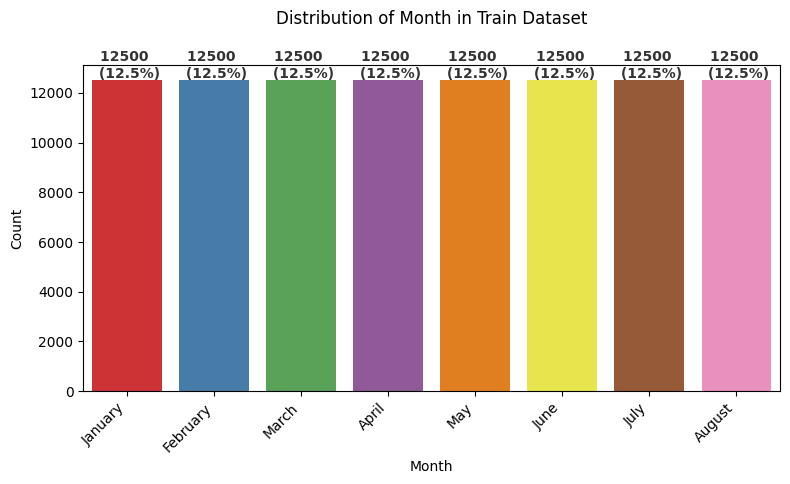

,Occupation
count,100000
unique,16
top,_______
freq,7062


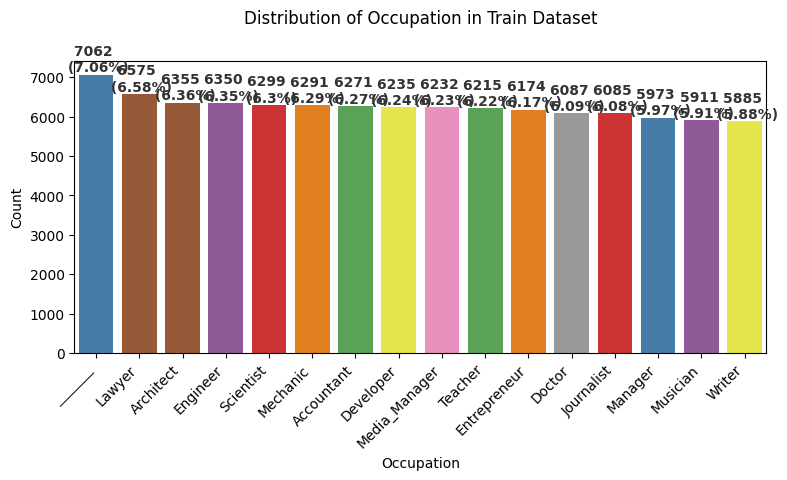

,Credit_Mix
count,100000
unique,4
top,Standard
freq,36479


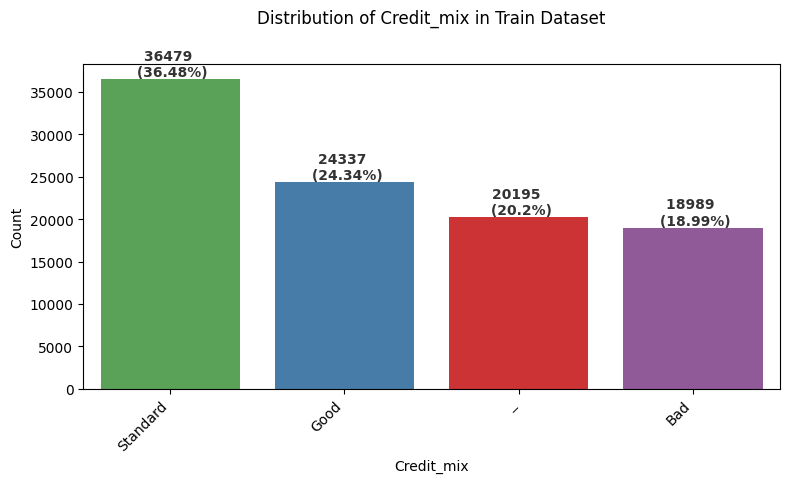

,Payment_Behaviour
count,100000
unique,7
top,Low_spent_Small_value_payments
freq,25513


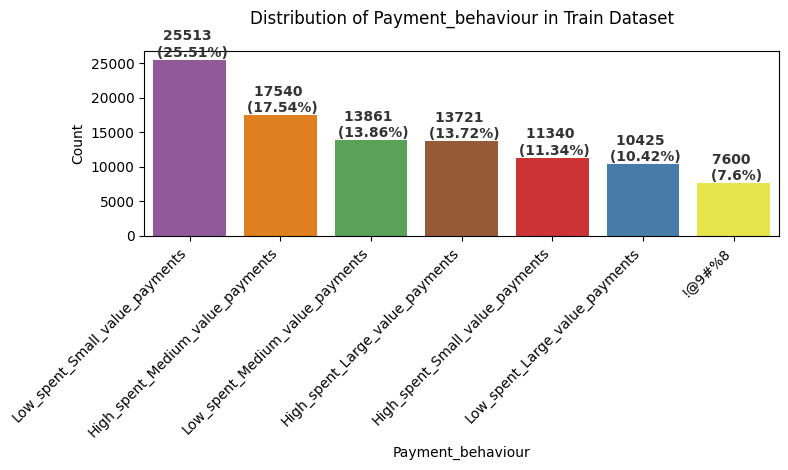

,Payment_of_Min_Amount
count,100000
unique,3
top,Yes
freq,52326


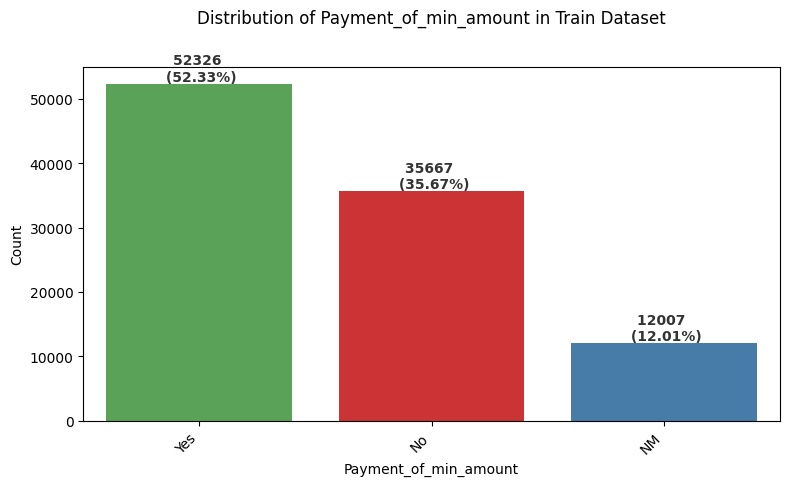

In [16]:
cat_columns = [ 'Month','Occupation',  'Credit_Mix', 'Payment_Behaviour', 'Payment_of_Min_Amount']

for col in cat_columns:
    plotting_cat_feature_distributions(df_train, col, dataset_name="Train Dataset", title_margin=1.1)

,Monthly_Inhand_Salary
count,84998.000000
mean,4194.170850
std,3183.686167
min,303.645417
25%,1625.568229
50%,3093.745000
75%,5957.448333
max,15204.633333


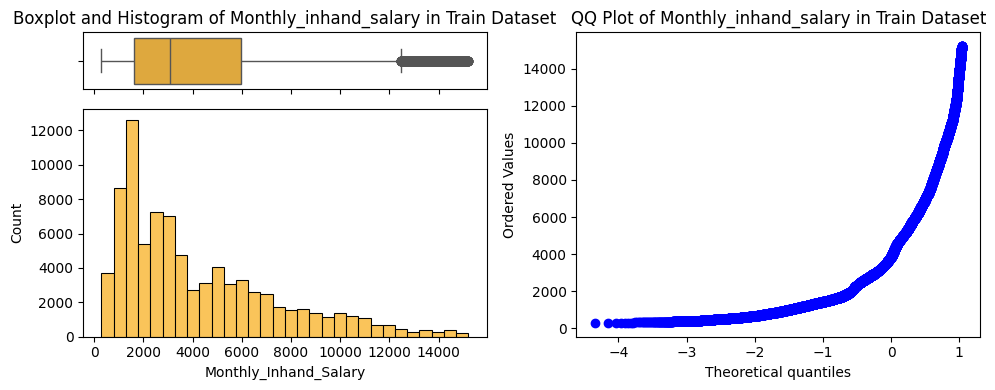

,Num_Bank_Accounts
count,100000.000000
mean,17.091280
std,117.404834
min,-1.000000
25%,3.000000
50%,6.000000
75%,7.000000
max,1798.000000


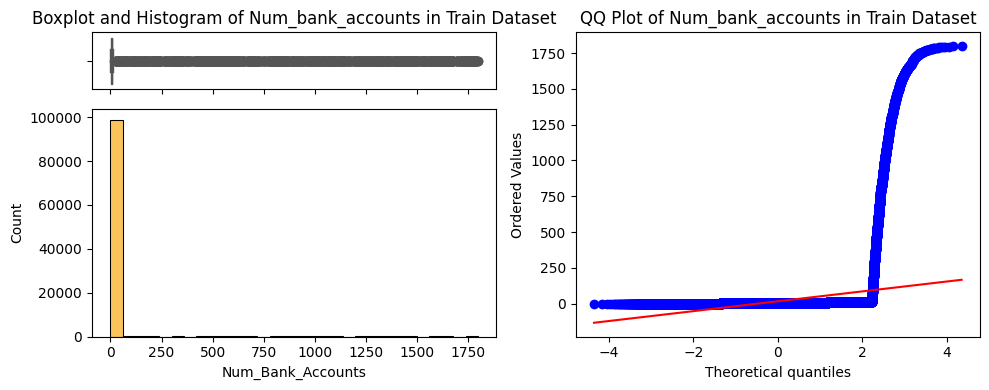

,Num_Credit_Card
count,100000.00000
mean,22.47443
std,129.05741
min,0.00000
25%,4.00000
50%,5.00000
75%,7.00000
max,1499.00000


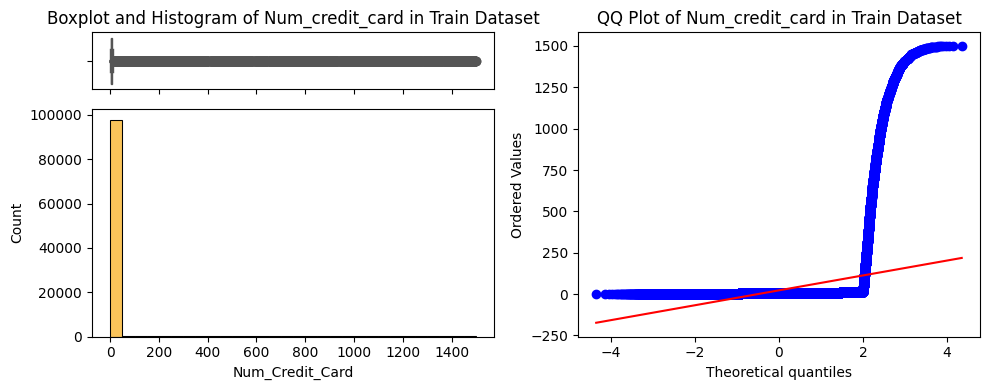

,Interest_Rate
count,100000.000000
mean,72.466040
std,466.422621
min,1.000000
25%,8.000000
50%,13.000000
75%,20.000000
max,5797.000000


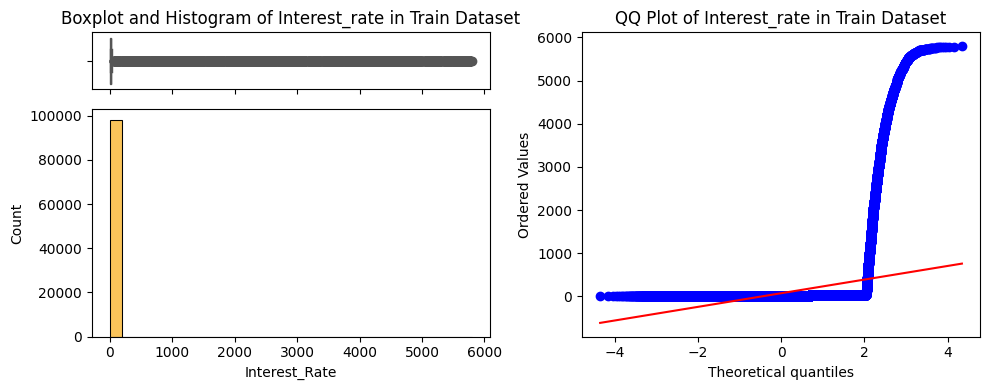

,Delay_from_due_date
count,100000.000000
mean,21.068780
std,14.860104
min,-5.000000
25%,10.000000
50%,18.000000
75%,28.000000
max,67.000000


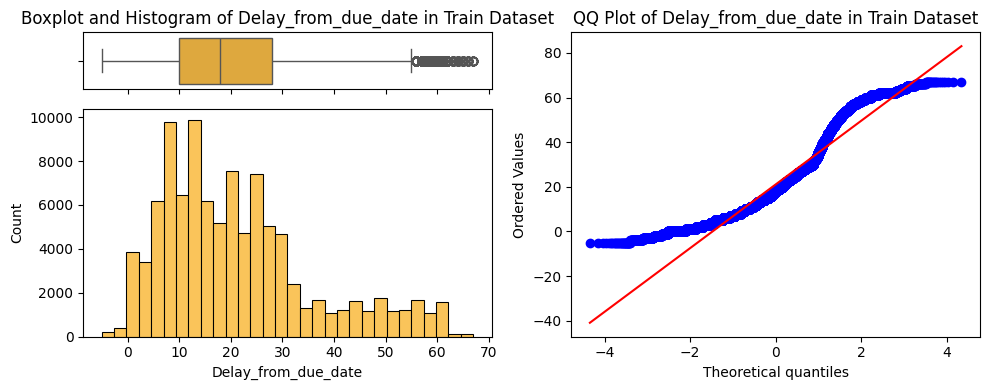

,Num_Credit_Inquiries
count,98035.000000
mean,27.754251
std,193.177339
min,0.000000
25%,3.000000
50%,6.000000
75%,9.000000
max,2597.000000


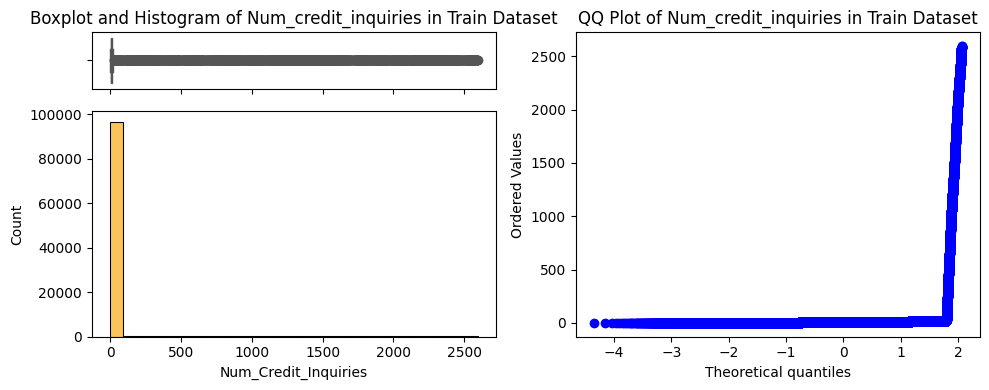

,Credit_Utilization_Ratio
count,100000.000000
mean,32.285173
std,5.116875
min,20.000000
25%,28.052567
50%,32.305784
75%,36.496663
max,50.000000


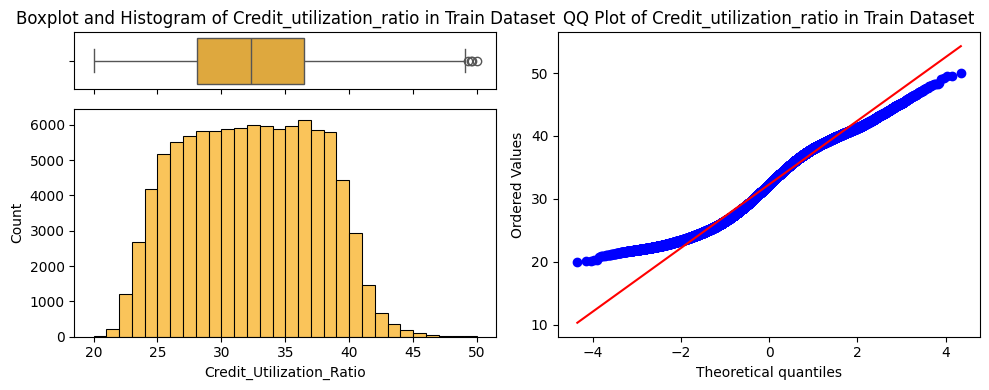

,Total_EMI_per_month
count,100000.000000
mean,1403.118217
std,8306.041270
min,0.000000
25%,30.306660
50%,69.249473
75%,161.224249
max,82331.000000


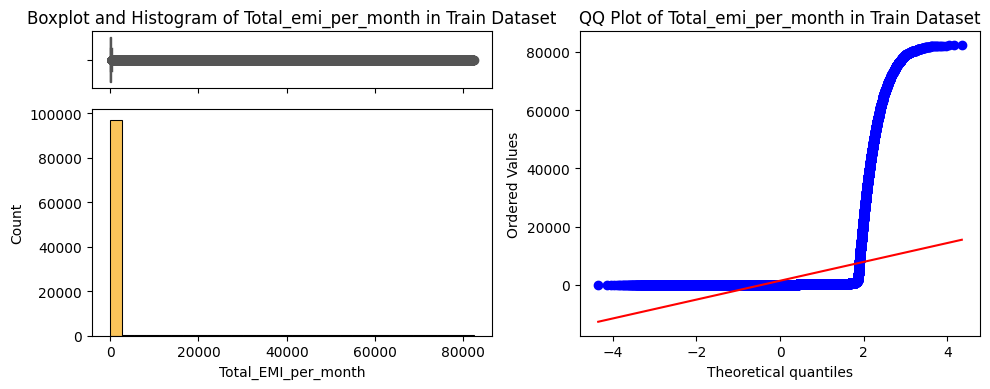

In [21]:
num_features = df_train.select_dtypes(include=['number']).columns.tolist()

for col in num_features:
    plotting_num_feature_distributions(df_train, col, dataset_name="Train Dataset")

### 3.2 Explore target variable

,Credit_Score
count,100000
unique,3
top,Standard
freq,53174


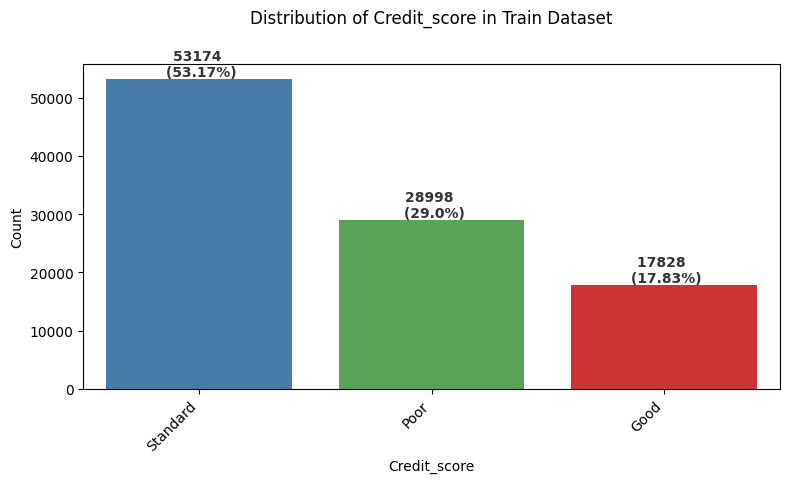

In [18]:
plotting_cat_feature_distributions(df_train, 'Credit_Score', dataset_name="Train Dataset", title_margin=1.1)

## 4. Feature Selection

### 4.1 Feature Selection Approach

### 4.2 Final Selected Features

## 5. Data Preprocessing

### 5.1 Data Cleaning

### 5.2. Feature Engineering

### 5.3 Data Transformation

## 6. Data Modeling

### 6.1 Generate Predictions with Baseline Model

### 6.2 Assess the Baseline Model

## 7. Model Evaluation

### 7.1 Generate Predictions with Model Selected

### 7.2 Assess the Selected Model

## 8. Insights and Conclusions